In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, MultiHeadAttention, Flatten, Concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from transformers import AutoTokenizer, AutoModel
import torch

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, LayerNormalization, GlobalAveragePooling1D, Conv1D

In [ ]:
statistics = pd.read_csv("istatistikler.csv")

news = pd.read_csv("haberler.csv")

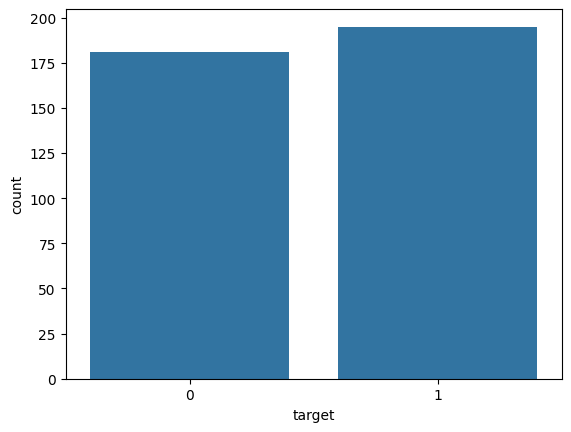

In [ ]:
# target
sns.countplot(data=statistics, x="target")
plt.show()

In [ ]:
news.head()

,title,text,clean_text,date,year,month,day
0,Savunmada Gelişenler ve yerinde sayanlar,Lefteris Moutis/moutis@eurohoops.net\nEurohoop...,lefteris eurohoops olarak eurolig deki takımla...,2015-03-02 13:56:00,2015,3,2
1,Galatasaray Fenerbahçe’ye Teslim Olmuyor,By Eurohoops team/info@eurohoops.netGalatasara...,galatasaraydüşüyor ama asla teslim olmuyor. si...,2015-05-24 17:10:00,2015,5,24
2,Avrupa’da Maç Programı ve Yayın Akışı,By Eurohoops Team/info@eurohoops.net\nEuroleag...,euroleague ve eurocup ta mücadele edecek takım...,2015-10-26 12:46:00,2015,10,26
3,“Atılan Üçlükler Fenerbahçe’yi Zor Durumda Bır...,"Torku Konyaspor koçu Aziz Bekir, maç sonu yapt...","torku konyaspor koçu aziz bekir, maç sonu yapt...",2015-10-26 21:06:00,2015,10,26
4,Fenerbahçe Tarihinde İlk!,By Eurohoops Team/info@eurohoops.net\nFenerbah...,"fenerbahçe, torku konyaspor maçında tarihinde ...",2015-10-27 10:34:00,2015,10,27


In [ ]:
statistics.head()

,Opposing Team,IsHome,Points,Performance Index Rating,Two-point %,Three-point %,Free-throw %,Offensive rebounds,Defensive rebounds,Total rebounds,Assists,Steals,Blocks,Turnovers,Day,Month,Year,Date,target
0,CSKA Moscow,1,81.0,76.0,42.9,38.5,62.5,13.0,30.0,43.0,20.0,5.0,5.0,19.0,2,1,2015,2015-01-02,0
1,Nizhny Novgorod,0,78.0,80.0,56.9,33.3,35.7,12.0,21.0,33.0,8.0,6.0,3.0,4.0,9,1,2015,2015-01-09,0
2,Olympiacos Piraeus,1,68.0,65.0,51.4,39.1,45.5,7.0,19.0,26.0,14.0,5.0,6.0,11.0,16,1,2015,2015-01-16,0
3,EA7 Emporio Armani Milan,0,82.0,99.0,63.0,21.1,85.7,13.0,20.0,33.0,18.0,9.0,3.0,9.0,22,1,2015,2015-01-22,1
4,Unicaja Malaga,0,68.0,81.0,57.9,27.8,69.2,8.0,30.0,38.0,16.0,9.0,3.0,15.0,30,1,2015,2015-01-30,0


### Data Alignment

In [ ]:
statistics['Date'] = pd.to_datetime(statistics['Date'])
news['date'] = pd.to_datetime(news['date'])

In [ ]:
def get_related_news(game_date, news_df, window_days=3):
    # Maçtan önceki pencereyi belirle
    start_date = game_date - timedelta(days=window_days)
    end_date = game_date - timedelta(days=1) # Maç gününü dahil etmiyoruz (garanti olsun)

    # O tarihler arasındaki haberleri filtrele
    mask = (news_df['date'] >= start_date) & (news_df['date'] <= end_date)
    related_news = news_df.loc[mask, 'clean_text'].tolist()

    # Haberleri tek bir metin olarak birleştir
    if len(related_news) > 0:
        return " ".join(related_news)
    else:
        return "no_news_available"

# Yeni sütunu oluştur
statistics['combined_news'] = statistics['Date'].apply(lambda x: get_related_news(x, news))

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(statistics.iloc[100])

,100
Opposing Team,Panathinaikos Superfoods Athens
IsHome,1
Points,67.0
Performance Index Rating,77.0
Two-point %,48.8
Three-point %,26.3
Free-throw %,71.4
Offensive rebounds,12.0
Defensive rebounds,26.0
Total rebounds,38.0


In [ ]:
df = statistics.copy()
df.head()

,Opposing Team,IsHome,Points,Performance Index Rating,Two-point %,Three-point %,Free-throw %,Offensive rebounds,Defensive rebounds,Total rebounds,Assists,Steals,Blocks,Turnovers,Day,Month,Year,Date,target,combined_news
0,CSKA Moscow,1,81.0,76.0,42.9,38.5,62.5,13.0,30.0,43.0,20.0,5.0,5.0,19.0,2,1,2015,2015-01-02,0,no_news_available
1,Nizhny Novgorod,0,78.0,80.0,56.9,33.3,35.7,12.0,21.0,33.0,8.0,6.0,3.0,4.0,9,1,2015,2015-01-09,0,no_news_available
2,Olympiacos Piraeus,1,68.0,65.0,51.4,39.1,45.5,7.0,19.0,26.0,14.0,5.0,6.0,11.0,16,1,2015,2015-01-16,0,no_news_available
3,EA7 Emporio Armani Milan,0,82.0,99.0,63.0,21.1,85.7,13.0,20.0,33.0,18.0,9.0,3.0,9.0,22,1,2015,2015-01-22,1,no_news_available
4,Unicaja Malaga,0,68.0,81.0,57.9,27.8,69.2,8.0,30.0,38.0,16.0,9.0,3.0,15.0,30,1,2015,2015-01-30,0,no_news_available


## MLP (statistics)


In [ ]:
X = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"])
y = df["target"]

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step
Fold 1 tamamlandı -> Acc: 0.8553 | F1: 0.8571 | AUC: 0.9459
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
Fold 2 tamamlandı -> Acc: 0.9067 | F1: 0.9091 | AUC: 0.9608


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Fold 3 tamamlandı -> Acc: 0.9467 | F1: 0.9500 | AUC: 0.9886
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Fold 4 tamamlandı -> Acc: 0.9467 | F1: 0.9474 | AUC: 0.9736
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Fold 5 tamamlandı -> Acc: 0.9200 | F1: 0.9231 | AUC: 0.9580

NİHAİ SONUÇLAR (Mean ± Std)
Accuracy:    0.9151 ± 0.0337
F1-Score:    0.9173 ± 0.0337
ROC-AUC:     0.9654 ± 0.0146
Precision:   0.9225 ± 0.0331
Recall:      0.9128 ± 0.0417
Sensitivity: 0.9128 ± 0.0417
Specificity: 0.9174 ± 0.0340

GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.91      0.92      0.91       181
    PIR > 90       0.92      0.91      0.92       195

    accuracy                           0.91       376
   macro avg       0.91      0.91      0.91       376
weighted avg       0.91      0.91      0.91       376



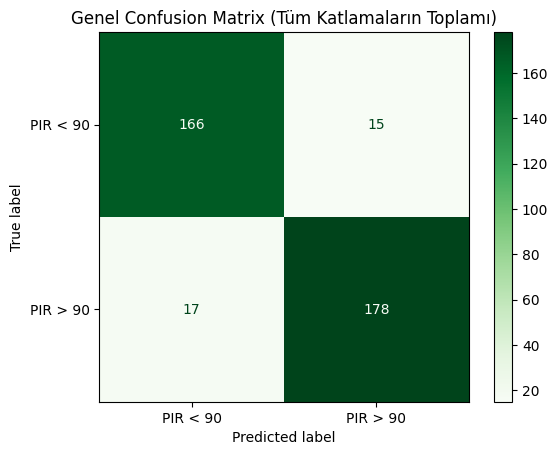

In [ ]:
# Metrikleri ve tüm tahminleri tutmak için listeler
fold_accuracies, fold_f1s, fold_precisions, fold_recalls = [], [], [], []
fold_sensitivities, fold_specificities, fold_aucs = [], [], []

# Tüm fold'lardaki gerçek değerleri ve tahminleri toplamak için
all_y_true = []
all_y_pred = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_cv)
    X_val_scaled = scaler.transform(X_val_cv)

    # MODEL MİMARİSİ
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(30, activation="relu"),
        Dense(15, activation="relu"),
        Dense(15, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(X_train_scaled, y_train_cv, epochs=50, batch_size=32, verbose=0)

    # TAHMİN (Olasılık ve Sınıf)
    y_probs = model.predict(X_val_scaled)
    y_pred = (y_probs > 0.5).astype("int32")

    # Genel Rapor İçin Tahminleri Sakla
    all_y_true.extend(y_val_cv)
    all_y_pred.extend(y_pred.flatten())

    # METRİKLER HESAPLAMA (Fold Bazlı)
    acc = accuracy_score(y_val_cv, y_pred)
    f1 = f1_score(y_val_cv, y_pred)
    auc = roc_auc_score(y_val_cv, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Listelere ekleme
    fold_accuracies.append(acc)
    fold_f1s.append(f1)
    fold_aucs.append(auc)
    fold_precisions.append(precision_score(y_val_cv, y_pred))
    fold_recalls.append(recall_score(y_val_cv, y_pred))
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)

    print(f"Fold {fold} tamamlandı -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

# --- TÜM FOLD'LAR BİTTİKTEN SONRA ---

print("\n" + "="*40)
print("NİHAİ SONUÇLAR (Mean ± Std)")
print(f"Accuracy:    {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"F1-Score:    {np.mean(fold_f1s):.4f} ± {np.std(fold_f1s):.4f}")
print(f"ROC-AUC:     {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")
print(f"Precision:   {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall:      {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"Sensitivity: {np.mean(fold_sensitivities):.4f} ± {np.std(fold_sensitivities):.4f}")
print(f"Specificity: {np.mean(fold_specificities):.4f} ± {np.std(fold_specificities):.4f}")
print("="*40)

# 1. Genel Classification Report (Tüm veriler için)
print("\nGENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true, all_y_pred, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PIR < 90', 'PIR > 90'])
disp.plot(cmap=plt.cm.Greens)
plt.title("Genel Confusion Matrix (Tüm Katlamaların Toplamı)")
plt.show()

### TabTransformer

Tabular Transformer (Transformer 1) 5-Fold CV Başlatılıyor...


>>> FOLD 1 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.8395 | 0.8289 | 0.9182

>>> FOLD 2 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.8919 | 0.8933 | 0.9366

>>> FOLD 3 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.9367 | 0.9333 | 0.9736

>>> FOLD 4 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.9136 | 0.9067 | 0.9630

>>> FOLD 5 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.9091 | 0.9067 | 0.9494

TABULAR TRANSFORMER FINAL REPORT | Mean ± Std
-------------------------------------------------------
ACC                            | 0.8938 ± 0.035
F1         

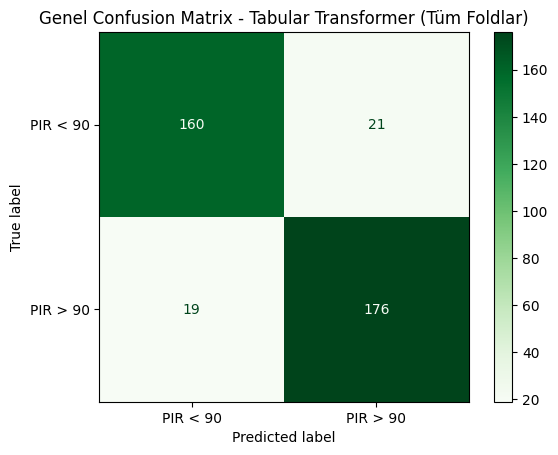

In [ ]:
def create_tabular_transformer(input_dim):
    inputs = Input(shape=(input_dim,))

    # 1. Feature Projection (Embedding Uzayı)
    x = Dense(64, activation='relu')(inputs)
    x = Reshape((1, 64))(x) # Attention 3B Tensör (Batch, Sequence, Dim) bekler

    # 2. Transformer Bloğu (Self-Attention)
    # Sayısal özellikler arasındaki gizli ilişkileri öğrenir
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(attention_output + x) # Residual connection

    # 3. Classification Head
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrikleri ve tüm tahminleri tutmak için yapılar
tab_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_tab = []
all_y_pred_tab = []

X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

print("Tabular Transformer (Transformer 1) 5-Fold CV Başlatılıyor...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    X_tr_raw, X_val_raw = X_stats_raw[train_idx], X_stats_raw[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = create_tabular_transformer(X_tr.shape[1])
    model.fit(X_tr, y_tr, epochs=30, batch_size=16, verbose=0)

    # Tahmin (Olasılık ve Sınıf)
    y_probs = model.predict(X_val, verbose=0)
    y_pred = (y_probs > 0.5).astype(int)

    # Genel Raporlama İçin Sakla
    all_y_true_tab.extend(y_val)
    all_y_pred_tab.extend(y_pred.flatten())

    # Metrikleri hesapla
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    tab_results['acc'].append(acc)
    tab_results['f1'].append(f1)
    tab_results['auc'].append(auc_val)
    tab_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    tab_results['rec'].append(recall_score(y_val, y_pred))
    tab_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    tab_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    print(f"\n>>> FOLD {fold} SONUÇLARI:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'AUC':6}")
    print("-" * 45)
    print(f"{'Tabular Trans.':15} | {f1:.4f} | {acc:.4f} | {auc_val:.4f}")


print("\n" + "="*55)
print(f"{'TABULAR TRANSFORMER FINAL REPORT':30} | {'Mean ± Std'}")
print("-" * 55)
for m in tab_results:
    print(f"{m.upper():30} | {np.mean(tab_results[m]):.4f} ± {np.std(tab_results[m]):.3f}")
print("="*55)

# 1. Genel Classification Report
print("\nTABULAR TRANSFORMER GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_tab, all_y_pred_tab, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_tab = confusion_matrix(all_y_true_tab, all_y_pred_tab)
disp_tab = ConfusionMatrixDisplay(confusion_matrix=cm_tab, display_labels=['PIR < 90', 'PIR > 90'])
disp_tab.plot(cmap=plt.cm.Greens)
plt.title("Genel Confusion Matrix - Tabular Transformer (Tüm Foldlar)")
plt.show()

### Informer

Informer Sayısal Model Testi Başlatılıyor (5-Fold CV)...


>>> FOLD 1 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.8312 | 0.8289 | 0.9245

>>> FOLD 2 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.9114 | 0.9067 | 0.9437

>>> FOLD 3 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.9383 | 0.9333 | 0.9772

>>> FOLD 4 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.9211 | 0.9200 | 0.9779

>>> FOLD 5 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.9091 | 0.9067 | 0.9630

INFORMER FINAL REPORT          | Mean ± Std
-------------------------------------------------------
ACC                            | 0.8991 ± 0.036
F1                

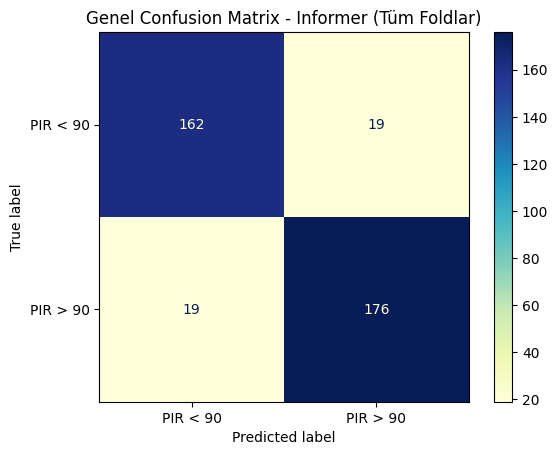

In [ ]:
def create_informer_lite_model(input_dim):
    inputs = Input(shape=(input_dim,))

    # 1. Feature Projection
    x = Dense(64, activation='relu')(inputs)
    x = Reshape((1, 64))(x)

    # 2. Informer-style Attention Block (8 Headed Attention)
    # İstatistikler arası global ilişkileri yakalamak için
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = LayerNormalization()(attention_output + x)

    # Informer Distilling (Conv1D ile en önemli özellikleri süzme/damıtma)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(x)
    x = Dropout(0.1)(x)

    # 3. Sınıflandırma Başlığı
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrik takibi ve tüm tahmin havuzu
inf_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_inf = []
all_y_pred_inf = []

X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

print("Informer Sayısal Model Testi Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    X_tr_raw, X_val_raw = X_stats_raw[train_idx], X_stats_raw[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = create_informer_lite_model(X_tr.shape[1])
    model.fit(X_tr, y_tr, epochs=25, batch_size=16, verbose=0)

    # Tahmin
    y_probs = model.predict(X_val, verbose=0)
    y_pred = (y_probs > 0.5).astype(int)

    # Genel raporlama için sakla
    all_y_true_inf.extend(y_val)
    all_y_pred_inf.extend(y_pred.flatten())

    # Metriklerin hesaplanması
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    inf_results['acc'].append(acc)
    inf_results['f1'].append(f1)
    inf_results['auc'].append(auc_val)
    inf_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    inf_results['rec'].append(recall_score(y_val, y_pred))
    inf_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    inf_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    print(f"\n>>> FOLD {fold} SONUÇLARI:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'AUC':6}")
    print("-" * 45)
    print(f"{'Informer':15} | {f1:.4f} | {acc:.4f} | {auc_val:.4f}")


print("\n" + "="*55)
print(f"{'INFORMER FINAL REPORT':30} | {'Mean ± Std'}")
print("-" * 55)
for m in inf_results:
    print(f"{m.upper():30} | {np.mean(inf_results[m]):.4f} ± {np.std(inf_results[m]):.3f}")
print("="*55)

# 1. Genel Classification Report
print("\nINFORMER GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_inf, all_y_pred_inf, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_inf = confusion_matrix(all_y_true_inf, all_y_pred_inf)
disp_inf = ConfusionMatrixDisplay(confusion_matrix=cm_inf, display_labels=['PIR < 90', 'PIR > 90'])
disp_inf.plot(cmap=plt.cm.YlGnBu)
plt.title("Genel Confusion Matrix - Informer (Tüm Foldlar)")
plt.show()

### BERTurk (news)

In [ ]:
# 1. Model ve Tokenizer Yükleme (BERTurk)
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
def get_bert_embeddings(text_list):
    # BERT'in 512 token sınırı vardır, metinleri buna göre kırpıyoruz
    inputs = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # [CLS] token'ının çıktısını alıyoruz (Metnin tamamını temsil eden 768-D vektör)
    # Rehberdeki text_feat (768) buna karşılık gelir [cite: 10]
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

# 2. Veri Setindeki Metinleri Vektöre Dönüştürme
print("Metinler vektörleştiriliyor (Bu işlem zaman alabilir)...")

text_features = []
for i in range(0, len(statistics)):
    text = statistics['combined_news'].iloc[i]
    emb = get_bert_embeddings([text])
    text_features.append(emb[0])

# Sonucu ana tabloya eklemek üzere numpy array yapıyoruz
X_text_features = np.array(text_features)
print(f"Metin özellik matrisi hazır: {X_text_features.shape}")

Metinler vektörleştiriliyor (Bu işlem zaman alabilir)...
Metin özellik matrisi hazır: (376, 768)


BERTurk Single-Modality Testi Başlıyor...

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
Fold 1 tamamlandı -> Acc: 0.5921 | F1: 0.5079 | AUC: 0.6085
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Fold 2 tamamlandı -> Acc: 0.4800 | F1: 0.4658 | AUC: 0.4117
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Fold 3 tamamlandı -> Acc: 0.5467 | F1: 0.5641 | AUC: 0.5310
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Fold 4 tamamlandı -> Acc: 0.4667 | F1: 0.5455 | AUC: 0.4526
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Fold 5 tamamlandı -> Acc: 0.4533 | F1: 0.4533 | AUC: 0.4288

TEXT-ONLY (BERTurk) NİHAİ SONUÇLAR (Mean ± Std)
Accuracy:    0.5078 ± 0.0530
F1-Score:    0.5073 ± 0.0432
ROC-AUC:     0.4865 ± 0.0734
Precision:   0.5386 ± 0.0712
Recall:      0.4923 ± 0.0817
Sensitivity: 0.4923 ± 0.0817
Specificity: 0.5234 ± 0.1536

BERTurk GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.49      0.52      0.51       181
    PIR > 90       0.53      0.49      0.51       195

    accurac

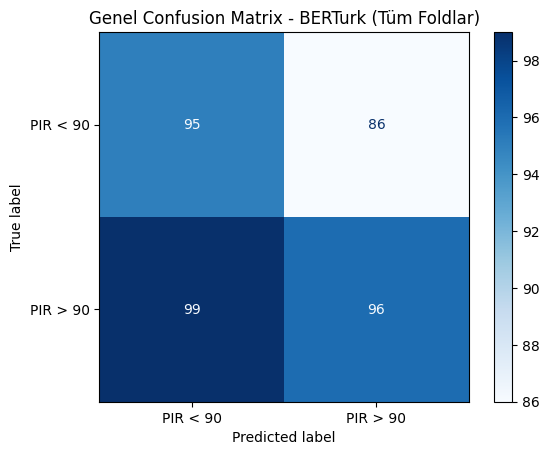

In [ ]:
# Metrik listelerini ve tüm tahminleri tutmak için listeler
text_acc, text_f1, text_prec, text_rec = [], [], [], []
text_sens, text_spec, text_aucs = [], [], []

all_y_true_text = []
all_y_pred_text = []

print("BERTurk Single-Modality Testi Başlıyor...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_text_features, y), 1):
    # Veriyi böl
    X_t_train, X_t_val = X_text_features[train_idx], X_text_features[val_idx]
    y_t_train, y_t_val = y[train_idx], y[val_idx]

    # Model: BERT vektörlerini sınıflayacak hiyerarşik MLP
    model_text = Sequential([
        Input(shape=(768,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model_text.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Eğitim
    model_text.fit(X_t_train, y_t_train, epochs=20, batch_size=16, verbose=0)

    # Tahmin (Olasılık ve Sınıf)
    y_probs = model_text.predict(X_t_val)
    y_pred = (y_probs > 0.5).astype(int)

    # Genel Raporlama İçin Sakla
    all_y_true_text.extend(y_t_val)
    all_y_pred_text.extend(y_pred.flatten())

    # Metrikleri hesapla
    acc = accuracy_score(y_t_val, y_pred)
    f1 = f1_score(y_t_val, y_pred)
    auc = roc_auc_score(y_t_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_t_val, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Listelere ekle
    text_acc.append(acc)
    text_f1.append(f1)
    text_prec.append(precision_score(y_t_val, y_pred))
    text_rec.append(recall_score(y_t_val, y_pred))
    text_sens.append(sensitivity)
    text_spec.append(specificity)
    text_aucs.append(auc)

    print(f"Fold {fold} tamamlandı -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")



print("\n" + "="*40)
print("TEXT-ONLY (BERTurk) NİHAİ SONUÇLAR (Mean ± Std)")
print(f"Accuracy:    {np.mean(text_acc):.4f} ± {np.std(text_acc):.4f}")
print(f"F1-Score:    {np.mean(text_f1):.4f} ± {np.std(text_f1):.4f}")
print(f"ROC-AUC:     {np.mean(text_aucs):.4f} ± {np.std(text_aucs):.4f}")
print(f"Precision:   {np.mean(text_prec):.4f} ± {np.std(text_prec):.4f}")
print(f"Recall:      {np.mean(text_rec):.4f} ± {np.std(text_rec):.4f}")
print(f"Sensitivity: {np.mean(text_sens):.4f} ± {np.std(text_sens):.4f}")
print(f"Specificity: {np.mean(text_spec):.4f} ± {np.std(text_spec):.4f}")
print("="*40)

# 1. Genel Classification Report
print("\nBERTurk GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_text, all_y_pred_text, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_text = confusion_matrix(all_y_true_text, all_y_pred_text)
disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=['PIR < 90', 'PIR > 90'])
disp_text.plot(cmap=plt.cm.Blues)
plt.title("Genel Confusion Matrix - BERTurk (Tüm Foldlar)")
plt.show()

### DistilBERT

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

DistilBERT özellikleri çıkarılıyor...

DistilBERT 5-Fold Cross-Validation Başlatılıyor...

>>> FOLD 1 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6783 | 0.5132 | 0.5440

>>> FOLD 2 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6600 | 0.5467 | 0.5050

>>> FOLD 3 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6842 | 0.5200 | 0.4142

>>> FOLD 4 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6275 | 0.4933 | 0.4647

>>> FOLD 5 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6471 | 0.5200 | 0.5919

DISTILBERT FINAL REPORT        | Mean ± Std
------------------------------------------------------------
ACC                          

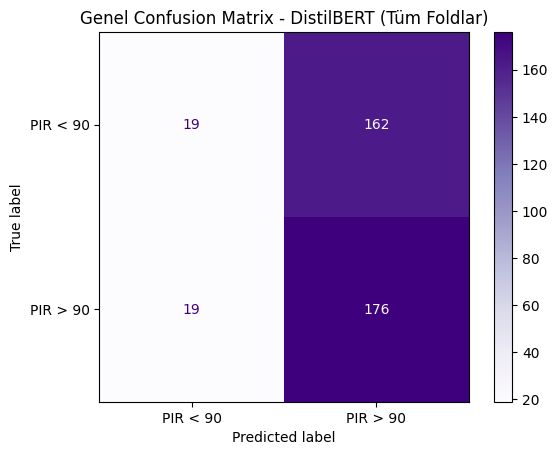

In [ ]:
# 1. DistilBERT Modelini Yükle (dbmdz/distilbert-base-turkish-cased)
distil_model_name = "dbmdz/distilbert-base-turkish-cased"
distil_tokenizer = AutoTokenizer.from_pretrained(distil_model_name)
distil_model = AutoModel.from_pretrained(distil_model_name)

def get_distilbert_embeddings(text_list):
    inputs = distil_tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = distil_model(**inputs)
    # [CLS] token'ı (0. indeks) metnin anlamsal özetidir (768-D)
    return outputs.last_hidden_state[:, 0, :].numpy()

# 2. Öznitelik Çıkarımı
print("DistilBERT özellikleri çıkarılıyor...")
distil_text_features = []
for i in range(len(statistics)):
    text = str(statistics['combined_news'].iloc[i])
    emb = get_distilbert_embeddings([text])
    distil_text_features.append(emb[0])

X_distil_feat = np.array(distil_text_features)
y = statistics['target'].values

# 3. Metrik Takibi ve Tahmin Havuzu
dist_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_dist = []
all_y_pred_dist = []

# 4. Single-Modality Testi (5-Fold CV)
print("\nDistilBERT 5-Fold Cross-Validation Başlatılıyor...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_distil_feat, y), 1):
    X_tr, X_val = X_distil_feat[train_idx], X_distil_feat[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # --- MODEL MİMARİSİ ---
    model = Sequential([
        Input(shape=(768,)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_tr, y_tr, epochs=15, batch_size=16, verbose=0)

    # --- TAHMİN ---
    y_probs = model.predict(X_val, verbose=0)
    y_pred = (y_probs > 0.5).astype(int)

    all_y_true_dist.extend(y_val)
    all_y_pred_dist.extend(y_pred.flatten())

    # --- METRİKLERİN HESAPLANMASI ---
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    dist_results['acc'].append(acc)
    dist_results['f1'].append(f1)
    dist_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    dist_results['rec'].append(recall_score(y_val, y_pred))
    dist_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    dist_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    dist_results['auc'].append(auc_val)

    print(f"\n>>> FOLD {fold} SONUÇLARI:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'AUC':6}")
    print("-" * 45)
    print(f"{'DistilBERT':15} | {f1:.4f} | {acc:.4f} | {auc_val:.4f}")

# --- RAPORLAMA ---
print("\n" + "="*60)
print(f"{'DISTILBERT FINAL REPORT':30} | {'Mean ± Std'}")
print("-" * 60)
for m in dist_results:
    print(f"{m.upper():30} | {np.mean(dist_results[m]):.4f} ± {np.std(dist_results[m]):.3f}")
print("="*60)

# 1. Genel Classification Report
print("\nDISTILBERT GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_dist, all_y_pred_dist, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_dist = confusion_matrix(all_y_true_dist, all_y_pred_dist)
disp_dist = ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=['PIR < 90', 'PIR > 90'])
disp_dist.plot(cmap=plt.cm.Purples)
plt.title("Genel Confusion Matrix - DistilBERT (Tüm Foldlar)")
plt.show()

### BiLSTM

BiLSTM Metin Modeli Testi Başlatılıyor (5-Fold CV)...

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Fold 1 tamamlandı -> Acc: 0.5132 | F1: 0.5316 | AUC: 0.4288
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Fold 2 tamamlandı -> Acc: 0.5200 | F1: 0.5135 | AUC: 0.4288
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Fold 3 tamamlandı -> Acc: 0.5867 | F1: 0.5974 | AUC: 0.4288
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Fold 4 tamamlandı -> Acc: 0.4667 | F1: 0.3103 | AUC: 0.4288
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Fold 5 tamamlandı -> Acc: 0.4933 | F1: 0.4062 | AUC: 0.4288

BiLSTM TEXT MODEL FINAL RESULTS (Mean ± Std)
ACC       : 0.5160 ± 0.0399
F1        : 0.4718 ± 0.1015
PREC      : 0.5334 ± 0.0426
REC       : 0.4359 ± 0.1337
SENS      : 0.4359 ± 0.1337
SPEC      : 0.6029 ± 0.0830
AUC       : 0.5130 ± 0.0275

BiLSTM GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.50      0.60      0.55       181
    PIR > 90       0.54      0.44      0.48       195

    accur

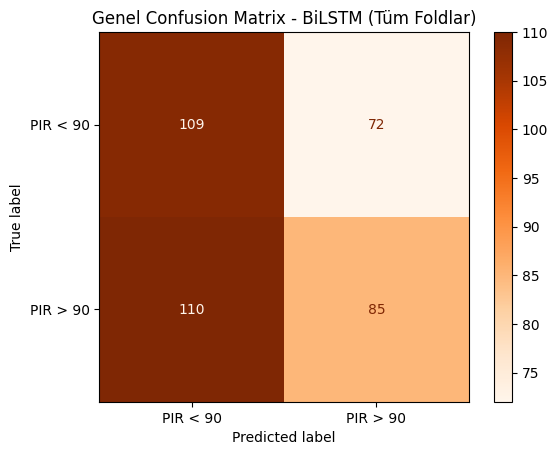

In [ ]:
# 1. VERİ HAZIRLIĞI
texts = statistics['combined_news'].astype(str).tolist()
y = statistics['target'].values

max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_text_padded = pad_sequences(sequences, maxlen=max_len)

# 2. METRİK TAKİBİ VE TAHMİN HAVUZU
bilstm_metrics = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_bilstm = []
all_y_pred_bilstm = []

# 3. 5-FOLD CV DÖNGÜSÜ
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("BiLSTM Metin Modeli Testi Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_text_padded, y), 1):
    X_tr, X_val = X_text_padded[train_idx], X_text_padded[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # --- MODEL MİMARİSİ ---
    model = Sequential([
        Input(shape=(max_len,)),
        Embedding(max_words, 128),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Eğitim
    model.fit(X_tr, y_tr, epochs=10, batch_size=32, verbose=0)

    # --- TAHMİN ---
    y_probs = model.predict(X_val)
    y_pred = (y_probs > 0.5).astype("int32")

    # Genel Raporlama İçin Sakla
    all_y_true_bilstm.extend(y_val)
    all_y_pred_bilstm.extend(y_pred.flatten())

    # Metrikleri hesapla
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    bilstm_metrics['acc'].append(acc)
    bilstm_metrics['f1'].append(f1)
    bilstm_metrics['prec'].append(precision_score(y_val, y_pred))
    bilstm_metrics['rec'].append(recall_score(y_val, y_pred))
    bilstm_metrics['sens'].append(tp / (tp + fn))
    bilstm_metrics['spec'].append(tn / (tn + fp))
    bilstm_metrics['auc'].append(auc_val)

    print(f"Fold {fold} tamamlandı -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


print("\n" + "="*45)
print("BiLSTM TEXT MODEL FINAL RESULTS (Mean ± Std)")
for metrik, degerler in bilstm_metrics.items():
    print(f"{metrik.upper():10}: {np.mean(degerler):.4f} ± {np.std(degerler):.4f}")
print("="*45)

# 1. Genel Classification Report
print("\nBiLSTM GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_bilstm, all_y_pred_bilstm, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_bilstm = confusion_matrix(all_y_true_bilstm, all_y_pred_bilstm)
disp_bilstm = ConfusionMatrixDisplay(confusion_matrix=cm_bilstm, display_labels=['PIR < 90', 'PIR > 90'])
disp_bilstm.plot(cmap=plt.cm.Oranges)
plt.title("Genel Confusion Matrix - BiLSTM (Tüm Foldlar)")
plt.show()

### Early Fusion

Early Fusion Başlatılıyor (MLP + DistilBERT)... Veri boyutu: (376, 780)
Fold 1 -> Acc: 0.8947 | F1: 0.9024 | AUC: 0.9785
Fold 2 -> Acc: 0.8667 | F1: 0.8611 | AUC: 0.9672
Fold 3 -> Acc: 0.9600 | F1: 0.9630 | AUC: 0.9950
Fold 4 -> Acc: 0.8800 | F1: 0.8696 | AUC: 0.9879
Fold 5 -> Acc: 0.8800 | F1: 0.8916 | AUC: 0.9722

EARLY FUSION (MLP + DISTILBERT) SONUÇLARI
ACC       : 0.8963 ± 0.033
F1        : 0.8975 ± 0.036
PREC      : 0.9139 ± 0.057
REC       : 0.8923 ± 0.092
SENS      : 0.8923 ± 0.092
SPEC      : 0.9009 ± 0.071
AUC       : 0.9802 ± 0.010

EARLY FUSION GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.89      0.90      0.89       181
    PIR > 90       0.91      0.89      0.90       195

    accuracy                           0.90       376
   macro avg       0.90      0.90      0.90       376
weighted avg       0.90      0.90      0.90       376



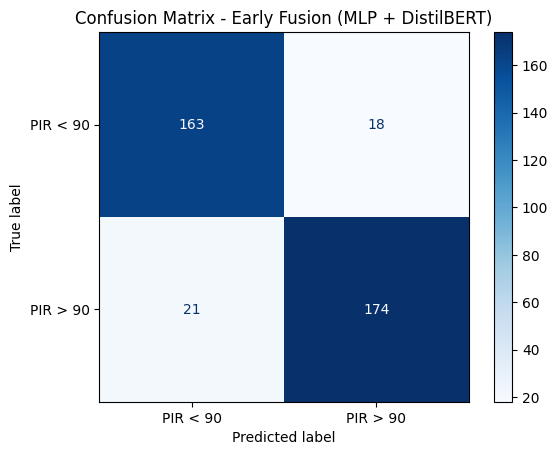

In [ ]:
# 1. Hazırlık: İstatistiksel Veriler ve DistilBERT Özelliklerini Birleştirme
# Not: X_distil_feat'in (N, 768) boyutunda hazır olduğunu varsayıyoruz.

# İstatistiksel sütunları seç (Metin ve hedef değişken hariç)
X_stats_raw = df.drop(columns=["target", "Performance Index Rating", "combined_news",
                               "Opposing Team", "Date", "Year", "Month", "Day"]).values

# İstatistiksel özellik sayısını dinamik olarak alalım (Ölçeklendirme için önemli)
num_stats_features = X_stats_raw.shape[1]

# Erken Füzyon: İstatistik + DistilBERT (768-D)
X_combined_raw = np.concatenate([X_stats_raw, X_distil_feat], axis=1)
y = df["target"].values

# Metrik Takibi
ef_metrics = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_ef = []
all_y_pred_ef = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Early Fusion Başlatılıyor (MLP + DistilBERT)... Veri boyutu: {X_combined_raw.shape}")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_combined_raw, y), 1):
    X_train, X_val = X_combined_raw[train_idx], X_combined_raw[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # --- ÖLÇEKLENDİRME ---
    # Sadece ilk kısımdaki (istatistiksel) özellikleri ölçeklendiriyoruz.
    # DistilBERT (768-D) zaten normalize bir yapıda olduğu için dokunmuyoruz.
    scaler = StandardScaler()
    X_train[:, :num_stats_features] = scaler.fit_transform(X_train[:, :num_stats_features])
    X_val[:, :num_stats_features] = scaler.transform(X_val[:, :num_stats_features])

    # --- MODEL MİMARİSİ (MLP) ---
    # İstatistik için en yüksek veren MLP yapısını füzyona uyarlıyoruz
    model = Sequential([
        Input(shape=(X_combined_raw.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Batch size ve epoch değerlerini ihtiyaca göre ayarlayabilirsin
    model.fit(X_train, y_train, epochs=25, batch_size=16, verbose=0)

    # --- TAHMİN ---
    y_probs = model.predict(X_val, verbose=0)
    y_pred = (y_probs > 0.5).astype(int)

    all_y_true_ef.extend(y_val)
    all_y_pred_ef.extend(y_pred.flatten())

    # --- METRİKLER ---
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    ef_metrics['acc'].append(acc)
    ef_metrics['f1'].append(f1)
    ef_metrics['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    ef_metrics['rec'].append(recall_score(y_val, y_pred))
    ef_metrics['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    ef_metrics['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    ef_metrics['auc'].append(auc_val)

    print(f"Fold {fold} -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc_val:.4f}")

# --- FINAL RAPORLAMA ---
print("\n" + "="*50)
print("EARLY FUSION (MLP + DISTILBERT) SONUÇLARI")
for m in ef_metrics:
    print(f"{m.upper():10}: {np.mean(ef_metrics[m]):.4f} ± {np.std(ef_metrics[m]):.3f}")
print("="*50)

# 1. Genel Classification Report (Tüm Foldların Toplamı)
print("\nEARLY FUSION GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_ef, all_y_pred_ef, target_names=['PIR < 90', 'PIR > 90']))

# Confusion Matrix Çizimi
cm_ef = confusion_matrix(all_y_true_ef, all_y_pred_ef)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ef, display_labels=['PIR < 90', 'PIR > 90'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Early Fusion (MLP + DistilBERT)")
plt.show()

### Intermediate Fusion

Intermediate Fusion (DistilBERT + MLP) Başlatılıyor...

Fold 1 -> Acc: 0.8421 | F1: 0.8462 | AUC: 0.9404
Fold 2 -> Acc: 0.8667 | F1: 0.8649 | AUC: 0.9480
Fold 3 -> Acc: 0.9067 | F1: 0.9136 | AUC: 0.9801
Fold 4 -> Acc: 0.9467 | F1: 0.9487 | AUC: 0.9758
Fold 5 -> Acc: 0.9200 | F1: 0.9211 | AUC: 0.9630

INTERMEDIATE FUSION FINAL RESULTS (Mean ± Std)
ACC       : 0.8964 ± 0.0375
F1        : 0.8989 ± 0.0378
PREC      : 0.9072 ± 0.0392
REC       : 0.8923 ± 0.0523
SENS      : 0.8923 ± 0.0523
SPEC      : 0.9009 ± 0.0438
AUC       : 0.9614 ± 0.0153

INTERMEDIATE FUSION GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.89      0.90      0.89       181
    PIR > 90       0.91      0.89      0.90       195

    accuracy                           0.90       376
   macro avg       0.90      0.90      0.90       376
weighted avg       0.90      0.90      0.90       376



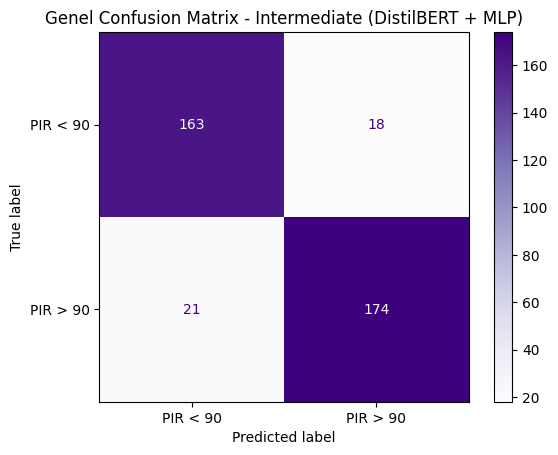

In [ ]:
def create_intermediate_model(stats_dim, text_dim):
    # 1. Giriş Katmanları
    stats_input = Input(shape=(stats_dim,), name='stats_input')
    text_input = Input(shape=(text_dim,), name='text_input')

    # 2. Projection (MLP Katmanları): İstatistiksel veriyi MLP mimarisine uygun işliyoruz
    # İstatistik kolu (MLP başarısını buraya yansıtıyoruz)
    stats_feat = Dense(128, activation='relu')(stats_input)
    stats_feat = Dropout(0.2)(stats_feat)
    stats_feat = Dense(128, activation='relu')(stats_feat) # Boyut eşitleme öncesi derinlik

    # Metin kolu (DistilBERT özelliklerini işleme)
    text_feat = Dense(128, activation='relu')(text_input)
    text_feat = Dropout(0.2)(text_feat)

    # 3. Boyut Genişletme (Attention için 3D Tensör: [Batch, Sequence_Len, Embedding_Dim])
    # Burada her modaliteyi 1 "kelime" gibi temsil ediyoruz (Seq_len=1)
    stats_feat_expanded = Reshape((1, 128))(stats_feat)
    text_feat_expanded = Reshape((1, 128))(text_feat)

    # 4. Cross-Attention Mekanizması
    # Query: İstatistik, Key/Value: Metin (İstatistiklerin metindeki karşılığını arıyoruz)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(
        query=stats_feat_expanded,
        value=text_feat_expanded
    )

    # 5. Birleştirme ve Final Karar Katmanları (MLP Yapısı)
    attn_flat = Flatten()(attn_output)
    # Hem dikkat çekilmiş bilgiyi hem de orijinal istatistiksel özeti birleştiriyoruz
    combined = Concatenate()([attn_flat, stats_feat])

    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[stats_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- VERİ HAZIRLIĞI VE EĞİTİM DÖNGÜSÜ ---

# ÖNEMLİ: X_distil_feat (N, 768) dizisinin hazır olduğunu varsayıyoruz
X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

int_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_int = []
all_y_pred_int = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Intermediate Fusion (DistilBERT + MLP) Başlatılıyor...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    # İstatistiksel veriler
    X_s_tr, X_s_val = X_stats_raw[train_idx], X_stats_raw[val_idx]
    # DistilBERT özelliklerini kullanıyoruz
    X_t_tr, X_t_val = X_distil_feat[train_idx], X_distil_feat[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # Ölçeklendirme (Sadece İstatistiklere)
    scaler = StandardScaler()
    X_s_tr = scaler.fit_transform(X_s_tr)
    X_s_val = scaler.transform(X_s_val)

    # Model oluştur ve eğit
    model = create_intermediate_model(X_s_tr.shape[1], X_t_tr.shape[1])
    model.fit([X_s_tr, X_t_tr], y_tr, epochs=30, batch_size=16, verbose=0)

    # Tahmin
    y_probs = model.predict([X_s_val, X_t_val], verbose=0)
    y_pred = (y_probs > 0.5).astype("int32")

    all_y_true_int.extend(y_val)
    all_y_pred_int.extend(y_pred.flatten())

    # Metrik Hesaplama
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    int_results['acc'].append(acc)
    int_results['f1'].append(f1)
    int_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    int_results['rec'].append(recall_score(y_val, y_pred))
    int_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    int_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    int_results['auc'].append(auc_val)

    print(f"Fold {fold} -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc_val:.4f}")

# --- NİHAİ RAPORLAMA ---
print("\n" + "="*50)
print("INTERMEDIATE FUSION FINAL RESULTS (Mean ± Std)")
for metrik, degerler in int_results.items():
    print(f"{metrik.upper():10}: {np.mean(degerler):.4f} ± {np.std(degerler):.4f}")
print("="*50)

print("\nINTERMEDIATE FUSION GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_int, all_y_pred_int, target_names=['PIR < 90', 'PIR > 90']))

# Confusion Matrix
cm_int = confusion_matrix(all_y_true_int, all_y_pred_int)
disp_int = ConfusionMatrixDisplay(confusion_matrix=cm_int, display_labels=['PIR < 90', 'PIR > 90'])
disp_int.plot(cmap=plt.cm.Purples)
plt.title("Genel Confusion Matrix - Intermediate (DistilBERT + MLP)")
plt.show()

### Late Fusion

Late Fusion İşlemleri Başlatılıyor (MLP + DistilBERT)...


>>> FOLD 1 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Majority        | 0.6783 | 0.5132 | 0.5000
Softmax_Mean    | 0.8684 | 0.8684 | 0.9556
Weighted        | 0.8684 | 0.8684 | 0.9556
Stacking        | 0.8831 | 0.8816 | 0.9556

>>> FOLD 2 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Majority        | 0.9231 | 0.9200 | 0.9199
Softmax_Mean    | 0.9231 | 0.9200 | 0.9594
Weighted        | 0.9231 | 0.9200 | 0.9566
Stacking        | 0.9114 | 0.9067 | 0.9601

>>> FOLD 3 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Majority        | 0.6972 | 0.5600 | 0.5427
Softmax_Mean    | 0.9250 | 0.9200 | 0.9872
Weighted        | 0.9250 | 0.9200 | 0.9872
Stacking        | 0.9250 | 0.9200 | 0.9872

>>> FOLD 4 SONUÇLARI:
Method          | F1     | Acc    | AUC   
------------------------

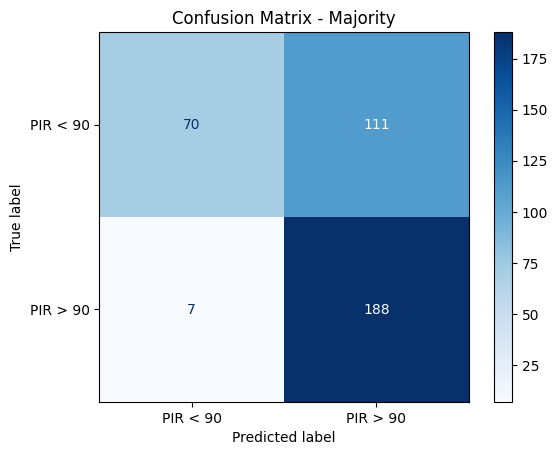


------------------------- SOFTMAX_MEAN NİHAİ ANALİZ -------------------------
              precision    recall  f1-score   support

    PIR < 90       0.90      0.92      0.91       181
    PIR > 90       0.93      0.91      0.92       195

    accuracy                           0.91       376
   macro avg       0.91      0.92      0.91       376
weighted avg       0.92      0.91      0.91       376



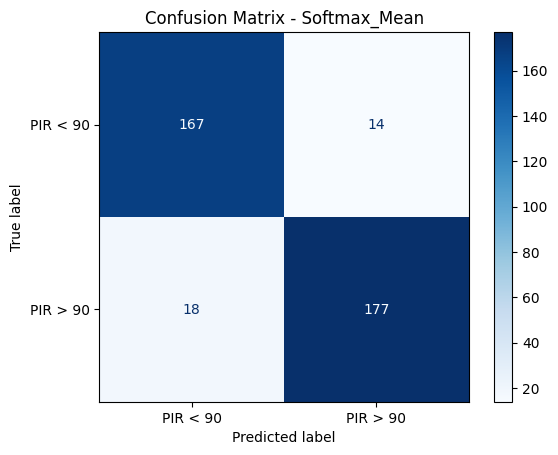


------------------------- WEIGHTED NİHAİ ANALİZ -------------------------
              precision    recall  f1-score   support

    PIR < 90       0.91      0.92      0.92       181
    PIR > 90       0.93      0.91      0.92       195

    accuracy                           0.92       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.92      0.92      0.92       376



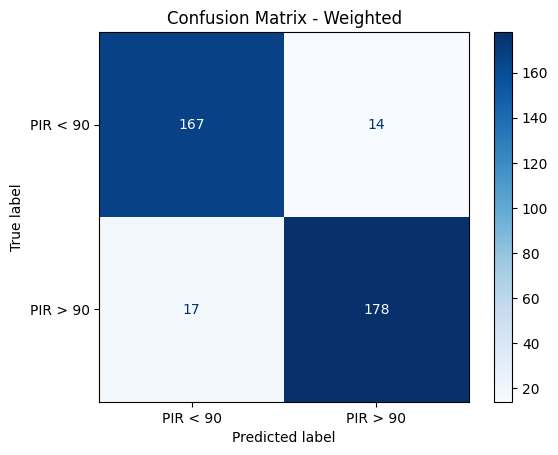


------------------------- STACKING NİHAİ ANALİZ -------------------------
              precision    recall  f1-score   support

    PIR < 90       0.91      0.92      0.91       181
    PIR > 90       0.92      0.92      0.92       195

    accuracy                           0.92       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.92      0.92      0.92       376



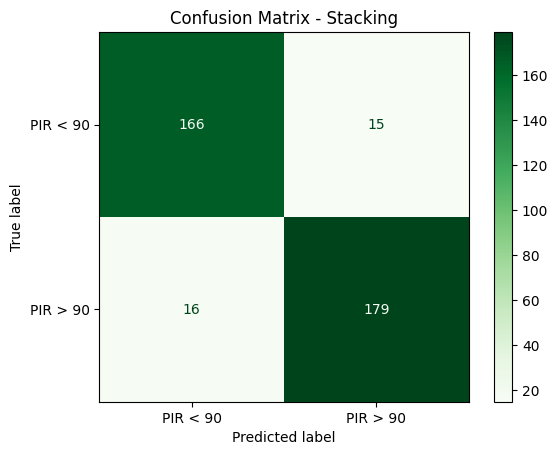

In [ ]:
# 1. Hazırlık
methods = ["Majority", "Softmax_Mean", "Weighted", "Stacking"]
late_results = {m: {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []} for m in methods}
all_preds = {m: {'true': [], 'pred': []} for m in methods}

# Verileri hazırla (X_distil_feat'in 768-D olduğu varsayılıyor)
X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

print("Late Fusion İşlemleri Başlatılıyor (MLP + DistilBERT)...\n")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    # İstatistik ve Metin verilerini ayır
    X_s_tr, X_s_val = X_stats_raw[train_idx], X_stats_raw[val_idx]
    X_t_tr, X_t_val = X_distil_feat[train_idx], X_distil_feat[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # Ölçeklendirme (Sadece İstatistiklere)
    scaler = StandardScaler()
    X_s_tr = scaler.fit_transform(X_s_tr)
    X_s_val = scaler.transform(X_s_val)

    # --- MODEL 1: İSTATİSTİK MODELİ (MLP) ---
    model_stats = Sequential([
        Input(shape=(X_s_tr.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_stats.compile(optimizer='adam', loss='binary_crossentropy')
    model_stats.fit(X_s_tr, y_tr, epochs=30, batch_size=16, verbose=0)
    prob_stats = model_stats.predict(X_s_val, verbose=0).flatten()

    # --- MODEL 2: METİN MODELİ (DistilBERT Features MLP) ---
    model_text = Sequential([
        Input(shape=(768,)), # DistilBERT embedding boyutu
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_text.compile(optimizer='adam', loss='binary_crossentropy')
    model_text.fit(X_t_tr, y_tr, epochs=15, batch_size=16, verbose=0)
    prob_text = model_text.predict(X_t_val, verbose=0).flatten()

    # --- FUSION HESAPLAMALARI ---

    # 1. Softmax (Mean) Probabilities
    p_soft = (prob_stats + prob_text) / 2

    # 2. Weighted (DistilBERT F1 skoru daha yüksek olduğu için ona daha fazla güveniyoruz)
    # Metin: 0.60, İstatistik: 0.40 ağırlık veriyoruz
    p_weight = (prob_stats * 0.4) + (prob_text * 0.6)

    # 3. Majority Voting
    p_maj_val = (((prob_stats > 0.5).astype(int) + (prob_text > 0.5).astype(int)) >= 1).astype(int)

    # 4. Stacking (Meta-Model)
    # Eğitim setinden olasılıkları topla
    X_meta_tr = np.column_stack([
        model_stats.predict(X_s_tr, verbose=0),
        model_text.predict(X_t_tr, verbose=0)
    ])
    X_meta_val = np.column_stack([prob_stats, prob_text])

    meta_model = LogisticRegression().fit(X_meta_tr, y_tr)
    p_stack_prob = meta_model.predict_proba(X_meta_val)[:, 1]
    p_stack_class = meta_model.predict(X_meta_val)

    # Tahmin ve Olasılık Sözlükleri
    probs_dict = {"Majority": p_maj_val, "Softmax_Mean": p_soft, "Weighted": p_weight, "Stacking": p_stack_prob}
    preds_dict = {"Majority": p_maj_val, "Softmax_Mean": (p_soft > 0.5).astype(int),
                  "Weighted": (p_weight > 0.5).astype(int), "Stacking": p_stack_class}

    print(f"\n>>> FOLD {fold} SONUÇLARI:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'AUC':6}")
    print("-" * 45)

    for m in methods:
        y_p = preds_dict[m]
        y_prob = probs_dict[m]

        # Metrikler
        acc = accuracy_score(y_val, y_p)
        f1 = f1_score(y_val, y_p)
        auc = roc_auc_score(y_val, y_prob)
        tn, fp, fn, tp = confusion_matrix(y_val, y_p).ravel()

        late_results[m]['acc'].append(acc)
        late_results[m]['f1'].append(f1)
        late_results[m]['auc'].append(auc)
        late_results[m]['prec'].append(precision_score(y_val, y_p, zero_division=0))
        late_results[m]['rec'].append(recall_score(y_val, y_p))
        late_results[m]['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        late_results[m]['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

        all_preds[m]['true'].extend(y_val)
        all_preds[m]['pred'].extend(y_p)

        print(f"{m:15} | {f1:.4f} | {acc:.4f} | {auc:.4f}")

# --- NİHAİ RAPORLAMA ---
print("\n" + "="*85)
print(f"{'Method':15} | {'F1 (Mean±Std)':20} | {'Acc (Mean±Std)':20} | {'AUC (Mean±Std)':20}")
print("-" * 85)
for m in methods:
    print(f"{m:15} | {np.mean(late_results[m]['f1']):.4f}±{np.std(late_results[m]['f1']):.3f} | "
          f"{np.mean(late_results[m]['acc']):.4f}±{np.std(late_results[m]['acc']):.3f} | "
          f"{np.mean(late_results[m]['auc']):.4f}±{np.std(late_results[m]['auc']):.3f}")

# Detaylı Sınıflandırma Raporları
for m in methods:
    print(f"\n{'-'*25} {m.upper()} NİHAİ ANALİZ {'-'*25}")
    print(classification_report(all_preds[m]['true'], all_preds[m]['pred'], target_names=['PIR < 90', 'PIR > 90']))

    cm = confusion_matrix(all_preds[m]['true'], all_preds[m]['pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PIR < 90', 'PIR > 90'])
    disp.plot(cmap=plt.cm.Greens if m == "Stacking" else plt.cm.Blues)
    plt.title(f"Confusion Matrix - {m}")
    plt.show()